<h1> Lab Six: Convolutional Network Architectures </h1>

<h4> Adam Ashcraft, Maya Muralidhar, Nora Potenti, Michael Watts </h4>

<h1> 1.0 Preparation </h1>

<h2> 1.1 Business Understanding </h2>

This is a dataset of approximately 4,300 images of flowers. These images have been taken from Flickr, Google, and Yandax and are divided into five categories: dasies, dandelions, roses, sunflowers, and tulips. The images were collected by performing a data scrape of these image hosting services by the dataset creator Alexander Mamaev. The images are in standard definition quality and do not have a standardized size. According to the Kaggle page, the data was collected to answer the question, “What kind of flower is that?” The creator also includes a prediction task for the data on Kaggle, “You can use this dataset to recognize plants from the photo.” 

This tool would primary serve the completely flower illiterate. It provides a very basic stepping stone into the wide world of botany for those with no experience in the field. With an application like this, a user will be able to successfully differentiate between different types of flowers based on subtler nuances than simply factors like color. Ideally, this would prevent someone from buying sunflowers instead of tulips simply because they are the same color. 


Another plant photo identification tool already exists in the market, Plantsnap. According to the Plantsnap website, it boasts a 96% success rate. In order for our tool to be considered viable, it must have at least, if not greater than, a 96% success rate.  

<hr>
Kaggle dataset: https://www.kaggle.com/alxmamaev/flowers-recognition <br>
Plantsnap self reported success rate: https://plantsnap.com/faq/

<h2> 1.2 Evaluation Criteria </h2>

Before we determine our evaluation criteria, let’s take a moment to look at our data.


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import glob
import pickle
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display
from sklearn.model_selection import train_test_split
import cv2
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from scipy.misc import imresize
from sklearn import metrics as mt


In [2]:
#use glob to get all file names in each folder
daisyFiles = glob.glob("flowers/daisy/*")
dandelionFiles = glob.glob("flowers/dandelion/*")
roseFiles = glob.glob("flowers/rose/*")
sunflowerFiles = glob.glob("flowers/sunflower/*")
tulipFiles = glob.glob("flowers/tulip/*")

daisies = []
dandelions = []
roses = []
sunflowers = []
tulips = []
#function to take image name, open image as numpy array and add to list
def addImageToArray(imageFileArray, imageArray):
    for file in imageFileArray:
        imageArray.append(np.asarray(Image.open(file)))
        
addImageToArray(daisyFiles,daisies)
addImageToArray(dandelionFiles,dandelions)
addImageToArray(roseFiles,roses)
addImageToArray(sunflowerFiles,sunflowers)
addImageToArray(tulipFiles,tulips)

([<matplotlib.patches.Wedge at 0x1a73df95c0>,
 [Text(0.932655,0.583228,'Daisy'),
  Text(-0.337028,1.0471,'Dandelion'),
  Text(-1.09692,-0.08226,'Rose'),
  Text(-0.421044,-1.01623,'Sunflower'),
  Text(0.830539,-0.721253,'Tulip')],
 [Text(0.508721,0.318124,'17.8%'),
  Text(-0.183834,0.571144,'24.3%'),
  Text(-0.59832,-0.0448691,'18.1%'),
  Text(-0.22966,-0.554307,'17.0%'),
  Text(0.453021,-0.393411,'22.8%')])

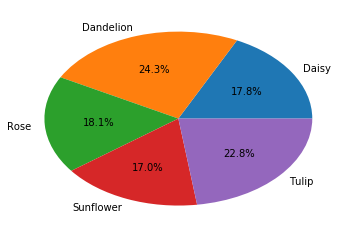

In [6]:
pieValues = [len(daisies), len(dandelions), len(roses), len(sunflowers), len(tulips)]
plt.pie(x=pieValues,labels=['Daisy', 'Dandelion', 'Rose', 'Sunflower','Tulip'], autopct='%1.1f%%')

A false negative and a false positive both represent the same idea here, an erroneous categorization of the flower for our user. Considering the fact, we are working with total flower novices, we will want to minimize both our false positive and false negatives rates as much as possible. We cannot assume our user is knowledgeable enough to detect them himself. We must also take into account the slight class imbalance we see in the above graphic. Dandelions and Tulips represent almost 50% of the classes in the data set. In order to focus on minimizing both the false positives and false negatives as well consider the class imbalance, we will use F1 score.


In [11]:
%%capture --no-display

croppedDaisies = [imresize(x,size=(33,50), interp='nearest') for x in daisies]    

croppedDandelions = [imresize(x,size=(33,50), interp='nearest') for x in dandelions]   

croppedRoses =[imresize(x,size=(33,50), interp='nearest') for x in roses]  

croppedSunflowers = [imresize(x,size=(33,50), interp='nearest') for x in sunflowers]    

croppedTulips = [imresize(x,size=(33,50), interp='nearest') for x in tulips] 

<h2> 1.2 Data Division </h2>

For our data division, we will be using a stratified shuffle split. The stratification will correct for the class imbalance of the data. The data is currently grouped into 5 groups, 1 per class. This is not an accurate reflection of how our model will be used. It is highly unlikely that the application will only ever see one kind of flower at a time, iteration after iteration. It will more than likely be exposed to a wide variety of flower with every use. In order to better model this, the data will be shuffled in order to split the groups of classes up and distribute them among the k-folds. 


In [12]:

X = np.array(croppedDaisies + croppedTulips + croppedDandelions + croppedRoses + croppedSunflowers)


4323


<h1> 2.0 Convolutional Neural Nets </h1>

<h2> 2.1 Data Expansion </h2>

We will want to assume that our photographer has no idea what features he is trying to capture in the image. This means he does not know good angles, lighting, or focus for his flower photograph. In order to mirror an amateur as much as possible with our data, we will create a wide variety of augmentations with our data generator.   


In [14]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False, #adding to each pixel
    samplewise_std_normalization=False, #adding to each picture
    zca_whitening=False,
    rotation_range=180, # used, Int. Degree range for random rotations.
    width_shift_range=0.5, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.5, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

<h2> 2.2 Simple CNN </h2>

In [18]:
y = np.array(len(croppedDaisies)*[0] + len(croppedTulips)*[1] + len(croppedDandelions)*[2] + len(croppedRoses)*[3] + len(croppedSunflowers)*[4])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
NUM_CLASSES = 5 
X_train_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_train]
X_train_resize = np.stack(X_train_resize,axis=0)
X_train_resize = flattenMatrix(X_train_resize)
X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
X_test_resize = np.stack(X_test_resize,axis=0)
X_test_resize = flattenMatrix(X_test_resize)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(len(X_test_resize[0]))

/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


NameError: name 'flattenMatrix' is not defined

In [8]:
mlp = Sequential()
mlp.add( Dense(input_dim=len(X_train_resize[0]), units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

mlp.fit(np.array(X_train_resize), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [9]:
cnn = Sequential()
cnn.add(Reshape((1,33,50), input_shape=(1,1650)))
cnn.add(Conv2D(filters=16, kernel_size= (10, 10), padding='same', input_shape=(1,33,50)))
cnn.add(Conv2D(filters=24, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(3, 5), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train_resize, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [10]:

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        f_cnn = mt.f1_score(y_test,yhat_cnn, average= 'samples')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f_mlp = mt.f1_score(y_test,yhat_mlp, , average= 'samples')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f_mlp))

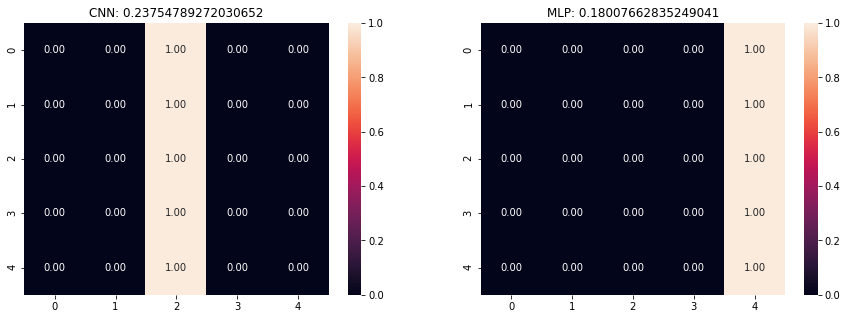

In [11]:
compare_mlp_cnn(cnn,mlp, np.array(X_test_resize),y_test)

In [12]:
daisies_color = [cv2.imread(img, 1) for img in daisyFiles]
dandelions_color = [cv2.imread(img, 1) for img in dandelionFiles]
roses_color = [cv2.imread(img, 1) for img in roseFiles]
sunflowers_color = [cv2.imread(img, 1) for img in sunflowerFiles]
tulips_color = [cv2.imread(img, 1) for img in tulipFiles]

In [13]:
def matrix_resize_color(arrayToAlter):
    croppedImages = []
    for i in range(0, len(arrayToAlter)):
        if(arrayToAlter[i].shape[0] >= 244 and arrayToAlter[i].shape[1] >= 327):
            #crop image
            image = arrayToAlter[i][0:244, 0:327]
            #final resize to ensure all matricies are the same size and remove any extra data from converting
            croppedImages.append(cv2.resize(image, (500, 330), interpolation = cv2.INTER_AREA))
    return croppedImages
cropped_daisies_color = matrix_resize_color(daisies_color)
cropped_dandelions_color = matrix_resize_color(dandelions_color)
cropped_roses_color = matrix_resize_color(roses_color)
cropped_sunflowers_color = matrix_resize_color(sunflowers_color)
cropped_tulips_color = matrix_resize_color(tulips_color)
cropped_daisies_color[0].shape

(330, 500, 3)

In [14]:
def flatten_matrix_color(array_of_matrices):
    total_array = []
    flattened_array = []
    for i in range(0, 3):
        for m in array_of_matrices:
            flattened_array.append(m[:,:,i].flatten())
        total_array.append(np.array(flattened_array))
        flattened_array = []
    return np.array(total_array).reshape(len(array_of_matrices), 3, int(array_of_matrices[0].size/3))

X_color = np.array(cropped_daisies_color + cropped_tulips_color + cropped_dandelions_color + cropped_roses_color + cropped_sunflowers_color)
# y is still y
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(X_color, y, test_size=0.2)
NUM_CLASSES = 5 
X_train_resize_color = [imresize(x,size=(33,50, 3), interp='nearest') for x in X_train_color]
X_train_resize_color = np.stack(X_train_resize_color,axis=0)
X_train_resize_color = flatten_matrix_color(X_train_resize_color)
X_test_resize_color = [imresize(x,size=(33,50, 3), interp='nearest') for x in X_test_color]
X_test_resize_color = np.stack(X_test_resize_color,axis=0)
X_test_resize_color = flatten_matrix_color(X_test_resize_color)
y_train_ohe_color = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_color = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [15]:
X_train_resize_color.shape

(1044, 3, 1650)

In [16]:
# Future transfer learning bit

<h2> 2.3 Resnet </h2>